In [1]:
# 1) Setup
import os, zipfile
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib

import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML
display(HTML("<style>.jp-OutputArea { overflow: visible !important; }</style>"))

dataset_path = r"C:\Users\amyha\OneDrive\Documents\DSC680\car_insurance_premium_dataset.csv"
df = pd.read_csv(dataset_path)

In [2]:
# 2) Summary statistics
display(df.describe(include='all'))

,Driver Age,Driver Experience,Previous Accidents,Annual Mileage (x1000 km),Car Manufacturing Year,Car Age,Insurance Premium ($)
count,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000
mean,41.575000,14.759000,2.5680,17.933000,2007.637000,17.363000,493.742250
std,13.765677,10.544292,1.6989,4.410665,10.363331,10.363331,5.909689
min,18.000000,0.000000,0.0000,11.000000,1990.000000,0.000000,477.050000
25%,30.000000,6.000000,1.0000,14.000000,1999.000000,8.000000,489.487500
50%,42.000000,13.000000,3.0000,18.000000,2008.000000,17.000000,493.950000
75%,53.000000,23.000000,4.0000,22.000000,2017.000000,26.000000,498.312500
max,65.000000,40.000000,5.0000,25.000000,2025.000000,35.000000,508.150000


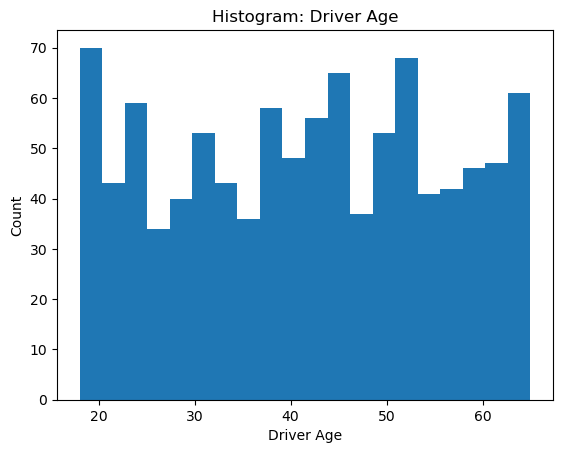

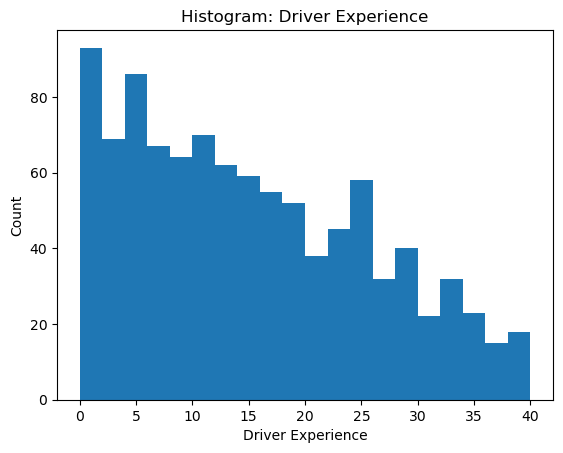

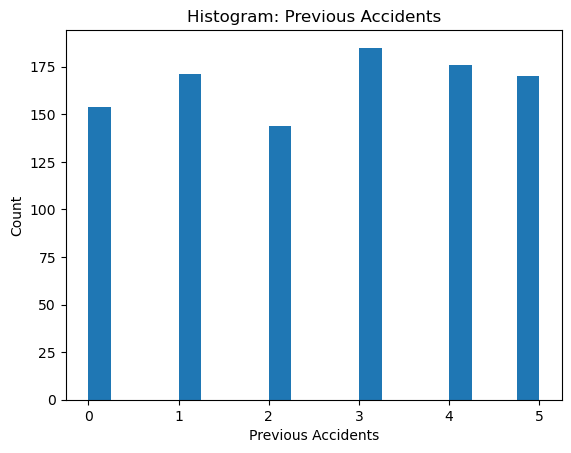

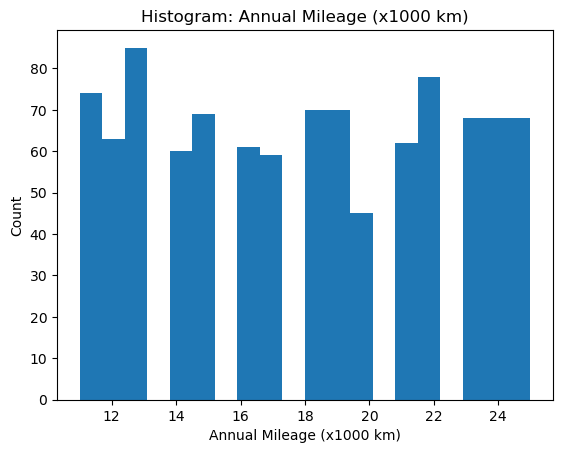

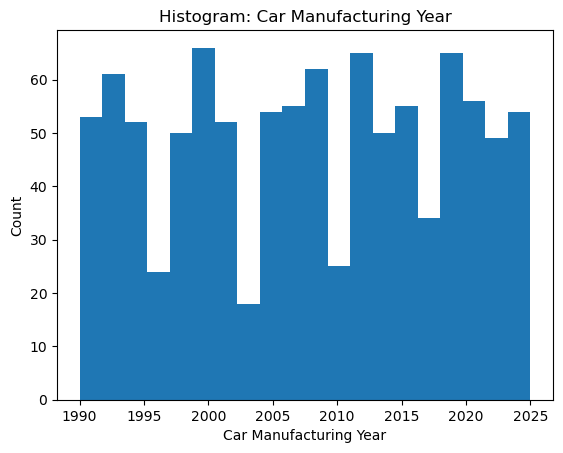

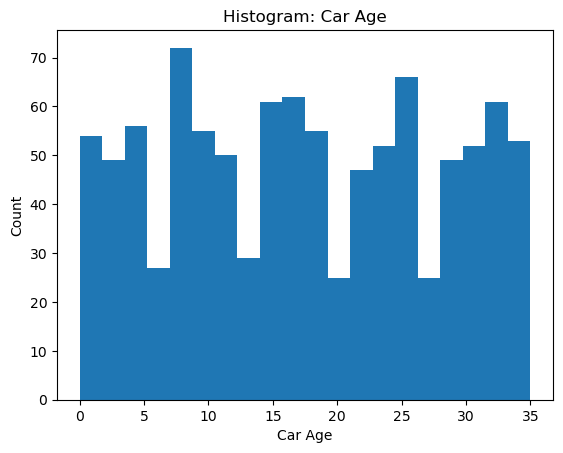

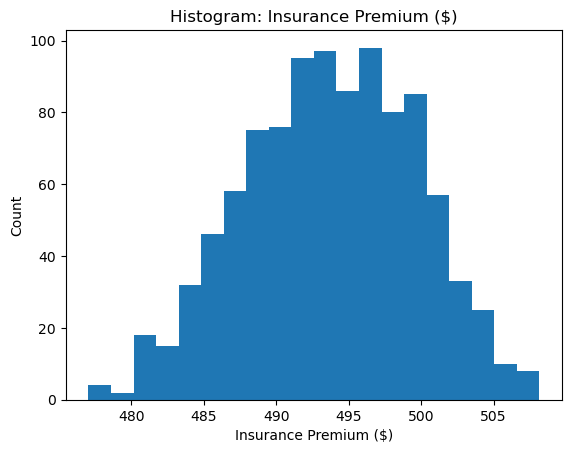

In [3]:
# 3) Distributions — one chart per column
numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
for col in numeric_cols:
    plt.figure()
    df[col].plot(kind='hist', bins=20, title=f'Histogram: {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

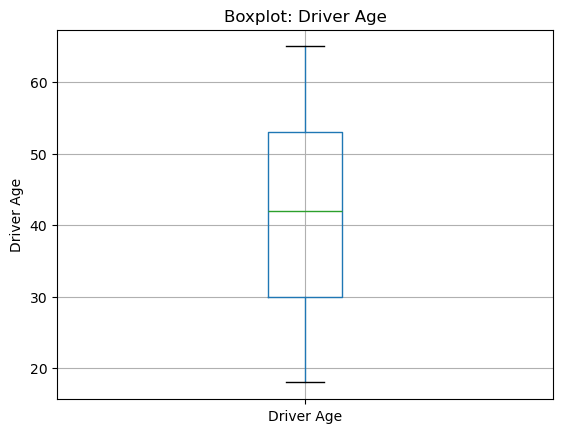

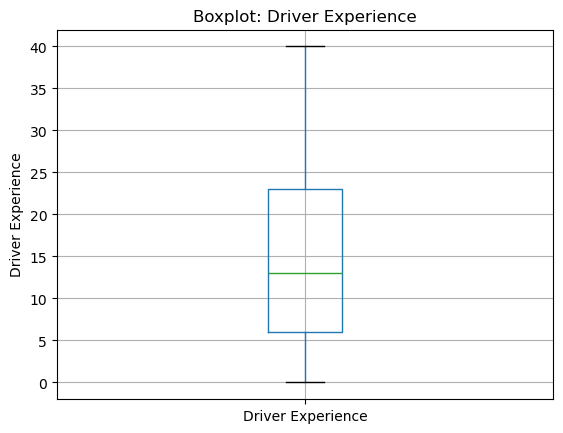

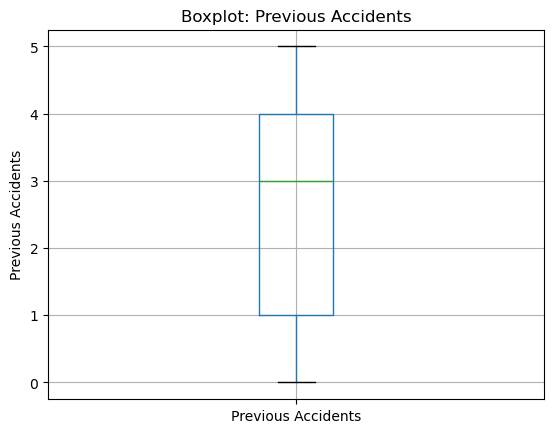

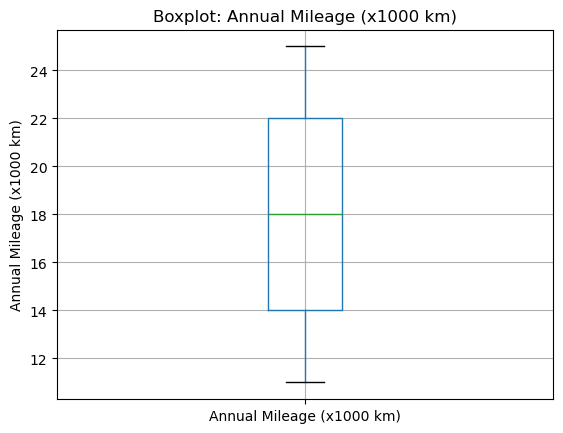

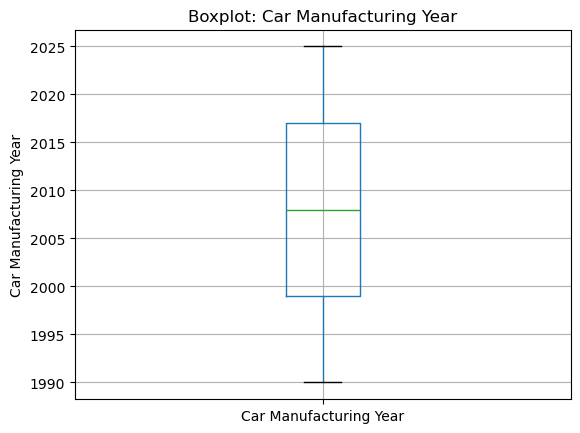

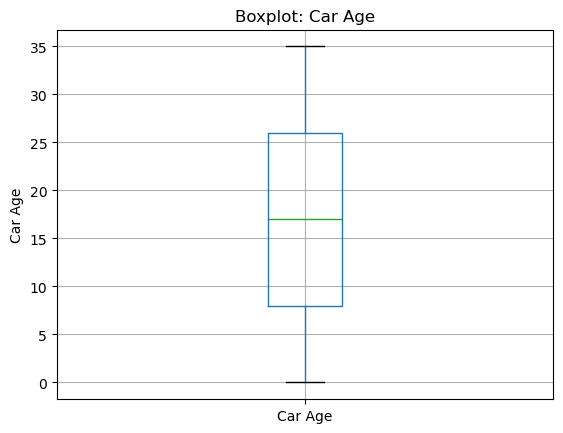

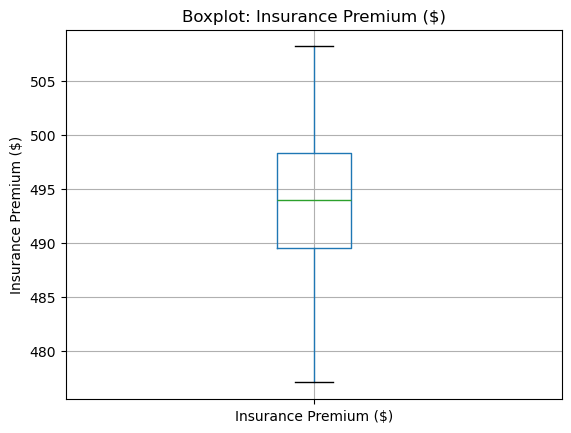

In [4]:
# 4) Box plots — one chart per column
for col in numeric_cols:
    plt.figure()
    df.boxplot(column=col)
    plt.title(f'Boxplot: {col}')
    plt.ylabel(col)
    plt.show()

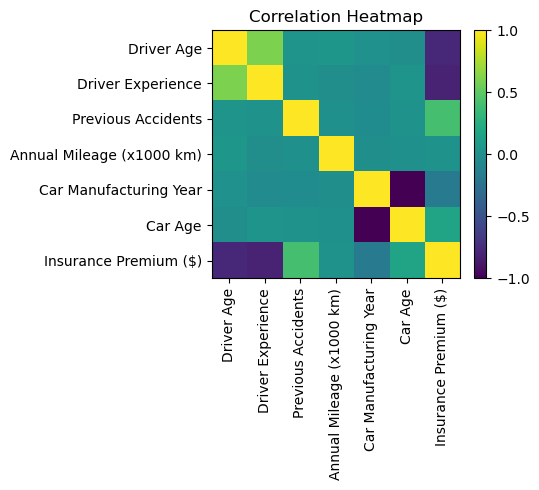

,Driver Age,Driver Experience,Previous Accidents,Annual Mileage (x1000 km),Car Manufacturing Year,Car Age,Insurance Premium ($)
Driver Age,1.000000,0.607890,0.031819,0.056822,0.008187,-0.008187,-0.776848
Driver Experience,0.607890,1.000000,0.020837,-0.014424,-0.038194,0.038194,-0.803323
Previous Accidents,0.031819,0.020837,1.000000,0.007088,-0.030123,0.030123,0.410786
Annual Mileage (x1000 km),0.056822,-0.014424,0.007088,1.000000,-0.002898,0.002898,0.022131
Car Manufacturing Year,0.008187,-0.038194,-0.030123,-0.002898,1.000000,-1.000000,-0.171829
Car Age,-0.008187,0.038194,0.030123,0.002898,-1.000000,1.000000,0.171829
Insurance Premium ($),-0.776848,-0.803323,0.410786,0.022131,-0.171829,0.171829,1.000000


In [5]:
# 5) Correlation heatmap 
corr = df[numeric_cols].corr(numeric_only=True)
plt.figure(figsize=(6,5))
im = plt.imshow(corr.values, interpolation='nearest')
plt.title('Correlation Heatmap')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
display(corr)

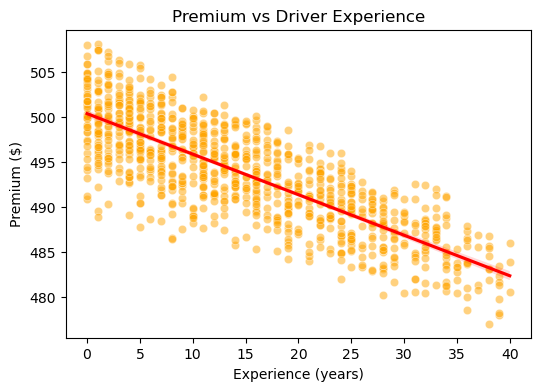

In [6]:
# 6) Scatter Plot
plt.figure(figsize=(6,4))
sns.scatterplot(x=df["Driver Experience"], 
                y=df["Insurance Premium ($)"], 
                alpha=0.5, color="orange")

sns.regplot(x=df["Driver Experience"], 
            y=df["Insurance Premium ($)"], 
            scatter=False, color="red")

plt.title("Premium vs Driver Experience")
plt.xlabel("Experience (years)")
plt.ylabel("Premium ($)")
plt.show()

In [12]:
# 7) Build and test models
TARGET = "Insurance Premium ($)" 
assert TARGET in df.columns, f"Target column '{TARGET}' not found."
X = df.drop(columns=[TARGET])
y = df[TARGET]

num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

models = {
    "LinearRegression": LinearRegression(),
    "RidgeCV": RidgeCV(alphas=np.logspace(-2, 2, 9)),  # 0.01..100
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=250, learning_rate=0.1, max_depth=3, random_state=42),
}

results = []
best_model = None
best_name = None
best_rmse = float("inf")

for name, model in models.items():
    pipe = Pipeline(steps=[("prep", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({"model": name, "test_rmse": rmse, "test_mae": mae, "test_r2": r2})
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = pipe
        best_name = name

results_df = pd.DataFrame(results).sort_values("test_rmse").reset_index(drop=True)
display(results_df)

,model,test_rmse,test_mae,test_r2
0,LinearRegression,5.084230e-14,3.808509e-14,1.000000
1,RidgeCV,5.499015e-05,4.545626e-05,1.000000
2,GradientBoosting,3.598881e-01,2.782540e-01,0.996182
3,RandomForest,7.357459e-01,5.486713e-01,0.984044


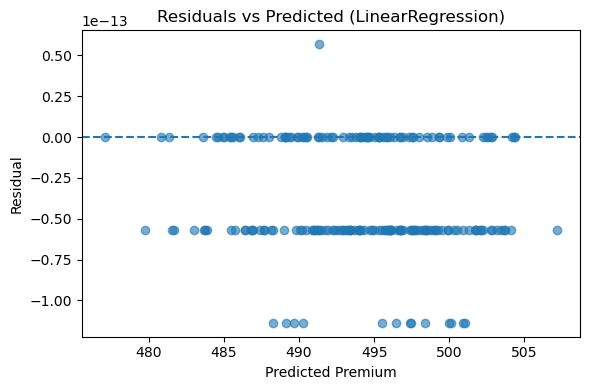

In [13]:
# 8) Residual Plot
y_pred_best = best_model.predict(X_test)
residuals = y_test - y_pred_best

plt.figure(figsize=(6,4))
plt.scatter(y_pred_best, residuals, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.title(f"Residuals vs Predicted ({best_name})")
plt.xlabel("Predicted Premium")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

In [15]:
# 9) Save best model and example inference
model_path = f'best_model_{best_name.replace(" ", "_").lower()}.joblib'
joblib.dump(best_model, model_path)
print('Best model:', best_name)

example = pd.DataFrame([{
    col: (X_train[col].median() if pd.api.types.is_numeric_dtype(X_train[col]) else X_train[col].mode().iloc[0])
    for col in X_train.columns
}])
display(example)
print('Prediction for example row:')
print(best_model.predict(example))

Best model: LinearRegression


,Driver Age,Driver Experience,Previous Accidents,Annual Mileage (x1000 km),Car Manufacturing Year,Car Age
0,42.0,13.0,3.0,18.0,2008.0,17.0


Prediction for example row:
[494.8]
